In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import dgl
import torch as th
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

### Préparation des interactions Client - Article

- Suppression des outliers dans les transactions
- Compilation des features

In [3]:
transactions = pd.read_pickle('pickles/transactions_with_week_number.pkl')

In [66]:
transactions_sampled = transactions.sample(frac = 0.1)
transactions_sampled.to_pickle('pickles/transactions_sampled.pkl')

In [5]:
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
articles = pd.read_pickle('pickles/articles_second_iteration.pkl')

In [5]:
customers.describe()

,FN,Active,age,average_cart_articles,average_cart_price,total_carts,total_articles,total_price,average_cart_interval,baby,...,repurchases,repurchases_interval,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,postal_code_group,group
count,1.371980e+06,1.371980e+06,1.371980e+06,1.362281e+06,1.362281e+06,1.371980e+06,1.371980e+06,1.362281e+06,914308.000000,1.362281e+06,...,1.371980e+06,1.362281e+06,1.371980e+06,1.371980e+06,1.371980e+06,1.371980e+06,1.371980e+06,1.371980e+06,1.371980e+06,1.371980e+06
mean,3.476217e-01,3.384918e-01,3.638249e+01,3.152104e+00,8.635714e-02,6.687019e+00,2.316967e+01,5.864855e-01,12.905269,5.021292e-02,...,1.098398e+00,1.601256e+00,9.771666e-02,3.432415e-01,1.838997e-01,1.553073e-01,1.527938e-01,5.304217e-02,2.923301e+00,3.449732e+00
std,4.762153e-01,4.731969e-01,1.423071e+01,2.343456e+00,6.934362e-02,9.872629e+00,3.915214e+01,1.047952e+00,13.456042,1.768992e-01,...,3.558472e+00,5.951089e+00,1.919715e-01,3.588772e-01,2.894079e-01,2.792319e-01,2.860559e-01,1.750757e-01,1.589091e+00,2.234190e+00
min,0.000000e+00,0.000000e+00,1.600000e+01,1.000000e+00,7.627119e-04,0.000000e+00,0.000000e+00,7.627119e-04,0.142857,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,2.400000e+01,1.800000e+00,4.411734e-02,1.000000e+00,3.000000e+00,8.300000e-02,4.875000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
50%,0.000000e+00,0.000000e+00,3.200000e+01,2.500000e+00,6.775593e-02,3.000000e+00,9.000000e+00,2.260169e-01,8.666667,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00
75%,1.000000e+00,1.000000e+00,4.900000e+01,4.000000e+00,1.056983e-01,8.000000e+00,2.700000e+01,6.452712e-01,15.690476,0.000000e+00,...,1.000000e+00,0.000000e+00,1.000000e-01,7.000000e-01,3.000000e-01,2.000000e-01,2.000000e-01,0.000000e+00,4.000000e+00,5.000000e+00
max,1.000000e+00,1.000000e+00,9.900000e+01,7.800000e+01,4.064424e+00,4.330000e+02,1.895000e+03,4.936141e+01,104.428571,1.000000e+00,...,3.980000e+02,1.040000e+02,9.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00,7.000000e+00


#### Suppression des outliers de la liste des transactions

In [6]:
# Taggage des outliers sur la table des clients (voir plus bas pour l'analyse)
customers['is_outlier'] = False
customers.loc[customers['total_articles'] > 500, 'is_outlier'] = True
customers.loc[customers['total_carts'] > 100, 'is_outlier'] = True
customers.loc[customers['repurchases'] > 50, 'is_outlier'] = True
customers['is_outlier'].value_counts()


False    1370431
True        1549
Name: is_outlier, dtype: int64

In [7]:
### Suppression des transactions des outliers.

customers_id_list = customers[customers['is_outlier'] == False]['customer_id'].unique()

transactions = transactions[transactions['customer_id'].isin(customers_id_list)]

In [8]:
transactions['day_of_week'] = transactions['t_dat'].dt.day_of_week
transactions['day_of_year'] = transactions['t_dat'].dt.day_of_year

In [9]:
transactions.to_pickle('pickles/transactions_without_outliers.pkl')
transactions.head()

,customer_id,article_id,t_dat,price,sales_channel_id,quantity,week_number,day_of_week,day_of_year
20523780,b6227fbf6968093cde31b5335a522c36827ed7cc715d01...,0685687004,2018-09-20,0.016542,2,1,104,3,263
1594079,0e129e8643d295d3f00e0d57f55d7d8dff13b82592f590...,0700828002,2018-09-20,0.050831,1,1,104,3,263
17533528,9b871e8d5636a7bad8c826012c7a2b1a04bc93d0075c6e...,0685683001,2018-09-20,0.025407,1,1,104,3,263
4498464,27c273bffa5d3b2558627f2bb5d8de121e2530cd7e2f10...,0541519024,2018-09-20,0.016932,1,1,104,3,263
23254377,ce698d3c10ec286f4aa65cee781ed8a9926eeb3fae330a...,0565379023,2018-09-20,0.008458,1,1,104,3,263


### Features clients

In [5]:
customers['fashion_news_frequency'].replace({'None': 'NONE'}, inplace = True)

# Typer les champs de catégorie
customers[['fashion_news_frequency','club_member_status']] = customers[['fashion_news_frequency','club_member_status']].astype('category')

customers.drop(columns = ['baby', 'divided', 'ladieswear', 'menswear', 'age', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price', 'sport', 'repurchases', 'is_outlier'], axis = 1, inplace = True)


In [6]:
from utils.dummify import Dummify

dummify = Dummify()

customers_full = dummify.transform(customers)
# Nan values for average_cart_interval / repurchases_interval
customers_full = customers_full.fillna(0)


In [7]:
customers_full.to_pickle('pickles/customers_gnn_full.pkl')
customers_full.head()

,customer_id,FN,Active,average_cart_interval,repurchases_interval,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,postal_code_group,group,club_member_status:ACTIVE,club_member_status:LEFT CLUB,club_member_status:NON ACTIVE,club_member_status:PRE-CREATE,fashion_news_frequency:Monthly,fashion_news_frequency:NONE,fashion_news_frequency:Regularly
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,9.809524,0.000000,0.0,0.0,0.0,0.6,0.4,0.0,4,7,1,0,0,0,0,1,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,4.259740,5.285714,0.0,1.0,0.0,0.0,0.0,0.0,4,1,1,0,0,0,0,1,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,17.285714,0.000000,0.1,0.9,0.0,0.0,0.0,0.0,4,1,1,0,0,0,0,1,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0.000000,0.000000,0.0,0.0,0.0,0.1,0.9,0.0,1,4,1,0,0,0,0,1,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,19.142857,2.000000,0.0,0.0,0.0,0.3,0.7,0.0,1,3,1,0,0,0,0,0,1


### Features articles
- Features complètes (~ 600 colonnes)
- Features réduites (~ 150 colonnes)

In [8]:
from utils.dummify import Dummify

# Colonnes inutilisées
columns_to_drop = ['total_purchases', 'average_quantity',
       'average_price', 'age_around_15', 'age_around_25',
       'age_around_35', 'age_around_45', 'age_around_55', 'age_around_65',
       'repurchases', 'repurchase_interval']

# Colonnes à traiter comme catégories
categories = ['product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name', 'perceived_colour_master_name',
       'department_name', 'index_name', 'index_group_name', 'section_name',
       'garment_group_name']

# Colonnes à enlever dans le jeu de donnée restreint (à mettre à la fin dans le jeu de données complet pour pouvoir le tronquer selon un paramètre du script)
to_drop_in_medium =  ['product_type_name',
       'graphical_appearance_name', 'colour_group_name',
       'department_name', ]

# Préparation du set
articles.drop(columns = columns_to_drop, axis = 1, inplace = True)

articles['has_image'] = articles['has_image'].astype(int)

articles[categories] = articles[categories].astype('category')

dummify = Dummify()

# Format restreint (medium)
articles_medium = articles.drop(columns = to_drop_in_medium, axis = 1)

articles_medium = dummify.transform(articles_medium)

# Catégories du format complet
article_extra_features = dummify.transform(articles[to_drop_in_medium])

articles_full = pd.concat([articles_medium, article_extra_features], axis = 1)


In [9]:
articles_medium.to_pickle('pickles/articles_gnn_medium.pkl')
articles_medium.head(1)

,article_id,has_image,product_group_name:Accessories,product_group_name:Bags,product_group_name:Cosmetic,product_group_name:Fun,product_group_name:Furniture,product_group_name:Garment Full body,product_group_name:Garment Lower body,product_group_name:Garment Upper body,...,garment_group_name:Shorts,garment_group_name:Skirts,garment_group_name:Socks and Tights,garment_group_name:Special Offers,garment_group_name:Swimwear,garment_group_name:Trousers,garment_group_name:Trousers Denim,"garment_group_name:Under-, Nightwear",garment_group_name:Unknown,garment_group_name:Woven/Jersey/Knitted mix Baby
0,0108775015,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
articles_full.to_pickle('pickles/articles_gnn_full.pkl')
articles_full.head(1)

,article_id,has_image,product_group_name:Accessories,product_group_name:Bags,product_group_name:Cosmetic,product_group_name:Fun,product_group_name:Furniture,product_group_name:Garment Full body,product_group_name:Garment Lower body,product_group_name:Garment Upper body,...,department_name:Young Girl Jersey Basic,department_name:Young Girl Jersey Fancy,department_name:Young Girl Knitwear,department_name:Young Girl Outdoor,department_name:Young Girl S&T,department_name:Young Girl Shoes,department_name:Young Girl Swimwear,department_name:Young Girl Trouser,department_name:Young Girl UW/NW,department_name:Young boy Swimwear
0,0108775015,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
articles_medium.to_pickle('pickles/articles_gnn_medium.pkl')

In [2]:
import pandas as pd
articles = pd.read_pickle('pickles/articles_gnn_full.pkl')
customers = pd.read_pickle('pickles/customers_gnn_full.pkl')

In [4]:
customers.isna().sum()

customer_id                              0
FN                                       0
Active                                   0
average_cart_interval               457672
repurchases_interval                  9699
age_around_15                            0
age_around_25                            0
age_around_35                            0
age_around_45                            0
age_around_55                            0
age_around_65                            0
postal_code_group                        0
group                                    0
club_member_status:ACTIVE                0
club_member_status:LEFT CLUB             0
club_member_status:NON ACTIVE            0
club_member_status:PRE-CREATE            0
fashion_news_frequency:Monthly           0
fashion_news_frequency:NONE              0
fashion_news_frequency:Regularly         0
dtype: int64

## Analyse complémentaire sur les transactions
- Proportion de rachats dans les transactions
- Corrélation entre les figures de ventes sur différentes semaines
- Corrélation entre les achats de plusieurs groupes de clients (afin d'identifier à partir de combien de combien de client on a un échantillon possiblement représentatif)
- Recherche d'outliers

### Corrélation entre les figures de ventes sur différentes semaines

In [37]:
import pandas as pd

transactions = pd.read_pickle('pickles/transactions.pkl')


In [2]:
transactions['day_number'] = (transactions['t_dat'].max() - transactions['t_dat'] ).dt.days

In [3]:
### Aligner les numéros de semaine d'une année sur l'autre
transactions.loc[transactions['day_number'] > 345, 'week_number'] = ((transactions['t_dat'].max() - transactions['t_dat'] ).dt.days - 366) // 7 + 52

In [4]:
### Nombre de ventes par articles par semaine
transactions['article_id'] = transactions['article_id'].astype('int32')
weekly_sales = transactions.groupby(['article_id', 'week_number'], as_index = False).agg(
    sales  = ('article_id', 'count')
)

weekly_sales['sales'] = weekly_sales['sales'].astype('int32')

In [38]:
### Copie dans un tableau avec le numéro de semaine en colonne
weeks_to_compare = [0, 1, 2, 51, 52, 53, 54, 10, 20, 30, 40]

article_ids = weekly_sales['article_id'].unique()
week_board = pd.DataFrame({'article_id': article_ids})

for week_number in weeks_to_compare:
    week_sales = weekly_sales[weekly_sales['week_number'] == week_number][['article_id', 'sales']].rename({'sales' : f"week_{week_number}"}, axis = 1)
    
    week_board = week_board.merge(week_sales, on = 'article_id', how = 'left')
    
week_board.fillna(0, inplace=True)

week_board.set_index('article_id', inplace = True)

week_board.head(10)

,week_0,week_1,week_2,week_51,week_52,week_53,week_54,week_10,week_20,week_30,week_40
article_id,,,,,,,,,,,
108775015,0.0,0.0,0.0,7.0,2.0,2.0,0.0,0.0,0.0,1.0,6.0
108775044,2.0,2.0,1.0,3.0,3.0,4.0,4.0,11.0,11.0,1.0,4.0
108775051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110065001,0.0,0.0,0.0,7.0,2.0,4.0,5.0,0.0,0.0,2.0,4.0
110065002,0.0,0.0,0.0,5.0,1.0,1.0,2.0,2.0,0.0,1.0,3.0
110065011,0.0,0.0,0.0,6.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0
111565001,25.0,27.0,27.0,37.0,24.0,35.0,28.0,24.0,37.0,32.0,70.0
111565003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111586001,39.0,64.0,78.0,254.0,151.0,145.0,108.0,18.0,0.0,124.0,239.0


<AxesSubplot:>

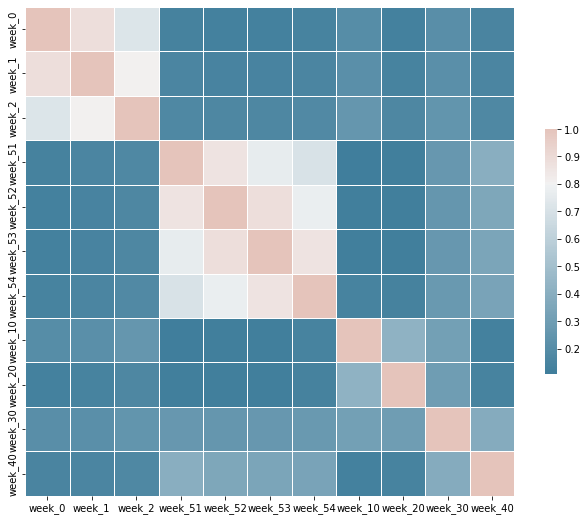

In [45]:
# Affichage des corrélations
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

table = week_board.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(table, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(table, cmap=cmap, vmax=1, center=0.8,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Proportion de rachats sur l'ensemble des transactions

In [5]:
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
customers['total_articles_bucketed'] = pd.qcut(customers['total_articles'], 5)
customers['total_articles_bucketed'].value_counts()

(-0.001, 3.0]     364340
(6.0, 14.0]       269342
(14.0, 34.0]      267464
(34.0, 1895.0]    267297
(3.0, 6.0]        203537
Name: total_articles_bucketed, dtype: int64

In [6]:
transactions_by_customer = transactions.groupby(['customer_id', 'article_id'], as_index = False).agg(
    sales = ('article_id', 'count')
)
transactions_by_customer = transactions_by_customer.groupby('customer_id', as_index = False).agg(
    unique_articles = ('article_id', 'count'),
    sales = ('sales', 'sum')
)

transactions_by_customer = transactions_by_customer.merge(customers[['customer_id', 'total_articles_bucketed']], on = 'customer_id', how = 'left')
transactions_by_bucket = transactions_by_customer.groupby('total_articles_bucketed', as_index = False).agg(
    unique_articles = ('unique_articles', 'sum'),
    sales = ('sales', 'sum')
)

transactions_by_bucket['ratio'] = transactions_by_bucket['unique_articles'] / transactions_by_bucket['sales']

transactions_by_bucket.head(5)

,total_articles_bucketed,unique_articles,sales,ratio
0,"(-0.001, 3.0]",636986,645628,0.986615
1,"(3.0, 6.0]",902610,925301,0.975477
2,"(6.0, 14.0]",2403278,2480852,0.968731
3,"(14.0, 34.0]",5400692,5622636,0.960527
4,"(34.0, 1895.0]",17962873,19139002,0.938548


In [12]:
print("Ratio de rachats sur l'ensemble des transactions: ", 1 -transactions_by_bucket['unique_articles'].sum() / transactions_by_bucket['sales'].sum())

Ratio de rachats sur l'ensemble des transactions:  0.05230132529568954


### Corrélation entre les achats de plusieurs groupes de clients

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def heatmap(dataframe):

    table = dataframe.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(table, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(table, cmap=cmap, vmax=1, center=0.8,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
customers = customers.sample(frac = 1).reset_index()

In [7]:
transactions_by_customer = transactions.groupby(['customer_id', 'article_id'], as_index = False).agg(
    sales = ('article_id', 'count')
)

In [8]:
buckets = 200

customer_per_bucket = len(customers) // buckets

article_ids = weekly_sales['article_id'].unique()

customer_sales_board = pd.DataFrame({'article_id': article_ids})
customer_unique_board = customer_sales_board.copy()

article_ids = customers.loc[0 : buckets * customer_per_bucket, 'customer_id']

print(f"{customer_per_bucket} clients par paquet.")

for i in range(100):
    print(f"\rProcessing bucket {i}", end="")
    customer_bucket = customers.loc[i * customer_per_bucket : i * customer_per_bucket + customer_per_bucket][['customer_id']]
    
    sales = customer_bucket.merge(transactions_by_customer, on='customer_id', how='left')
    sales = sales.groupby('article_id', as_index = False).agg(
        unique = ('customer_id', 'count'),
        sales = ('sales', 'sum')
    ).rename({'unique': f"unique_{i}", 'sales': f"sales_{i}"}, axis = 1)
    
    customer_sales_board = customer_sales_board.merge(sales[['article_id', f"sales_{i}"]], on = 'article_id', how = 'left')
    customer_unique_board = customer_unique_board.merge(sales[['article_id', f"unique_{i}"]], on = 'article_id', how = 'left')
    
customer_sales_board.set_index('article_id', inplace = True)
customer_unique_board.set_index('article_id', inplace = True)

customer_sales_board.fillna(0, inplace = True)
customer_unique_board.fillna(0, inplace = True)

customer_sales_board.head(5)

6859 clients par paquet.
Processing bucket 99

,sales_0,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,...,sales_90,sales_91,sales_92,sales_93,sales_94,sales_95,sales_96,sales_97,sales_98,sales_99
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,45.0,33.0,46.0,36.0,42.0,28.0,33.0,45.0,41.0,31.0,...,39.0,36.0,27.0,39.0,40.0,37.0,35.0,49.0,32.0,48.0
108775044,33.0,26.0,32.0,20.0,41.0,30.0,30.0,24.0,35.0,37.0,...,26.0,20.0,18.0,29.0,24.0,26.0,31.0,39.0,31.0,23.0
108775051,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,...,2.0,NaN,2.0,2.0,1.0,1.0,2.0,NaN,NaN,2.0
110065001,7.0,2.0,2.0,2.0,6.0,4.0,3.0,6.0,4.0,8.0,...,4.0,5.0,6.0,10.0,7.0,5.0,4.0,5.0,10.0,1.0
110065002,3.0,1.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0,4.0,...,2.0,NaN,3.0,3.0,5.0,1.0,1.0,4.0,1.0,1.0


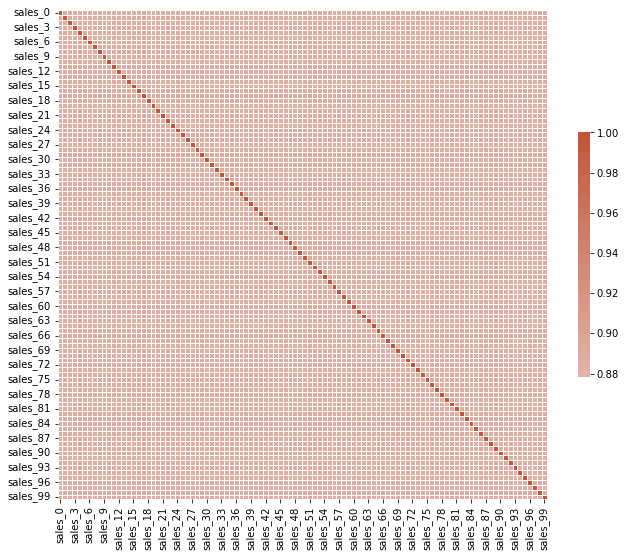

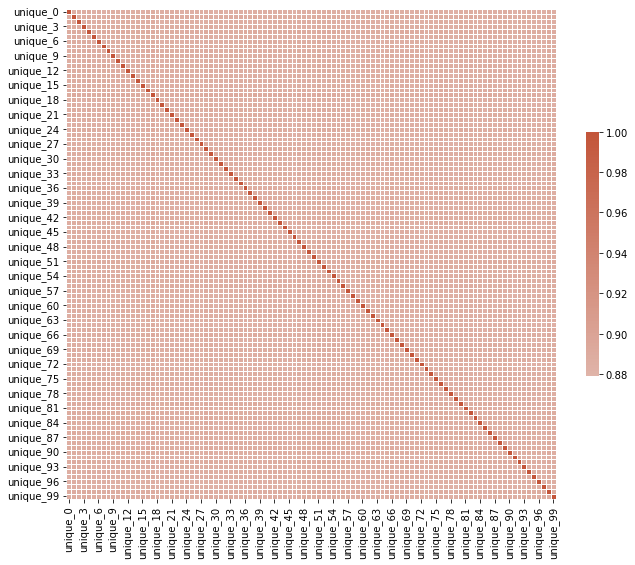

In [12]:
# Affichage des corrélations


heatmap(customer_sales_board)
heatmap(customer_unique_board)

Corrélation entre les utilisateurs de chaque semaine d'achat

In [16]:
article_ids = weekly_sales['article_id'].unique()

customer_sales_board = pd.DataFrame({'article_id': article_ids})
customer_unique_board = customer_sales_board.copy()

article_ids = customers.loc[0 : buckets * customer_per_bucket, 'customer_id']

for i in range(100):
    customer_ids = transactions[transactions['week_number'] == i]['customer_id'].unique()
    print(f"\rProcessing semaine {i}: {len(customer_ids)} clients    ", end="")
    
    sales = transactions_by_customer[transactions_by_customer['customer_id'].isin(customer_ids)]
    sales = sales.groupby('article_id', as_index = False).agg(
        unique = ('customer_id', 'count'),
        sales = ('sales', 'sum')
    ).rename({'unique': f"unique_{i}", 'sales': f"sales_{i}"}, axis = 1)
    
    customer_sales_board = customer_sales_board.merge(sales[['article_id', f"sales_{i}"]], on = 'article_id', how = 'left')
    customer_unique_board = customer_unique_board.merge(sales[['article_id', f"unique_{i}"]], on = 'article_id', how = 'left')
    
customer_sales_board.set_index('article_id', inplace = True)
customer_unique_board.set_index('article_id', inplace = True)

customer_sales_board.fillna(0, inplace = True)
customer_unique_board.fillna(0, inplace = True)

customer_sales_board.head(5)

Processing semaine 99: 97269 clientss

,sales_0,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,...,sales_90,sales_91,sales_92,sales_93,sales_94,sales_95,sales_96,sales_97,sales_98,sales_99
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,721.0,726.0,807.0,844.0,804.0,762.0,823.0,861.0,790.0,845.0,...,991.0,1357.0,1231.0,1197.0,1210.0,1891.0,1124.0,1237.0,1281.0,1541.0
108775044,575.0,566.0,603.0,656.0,622.0,619.0,668.0,710.0,683.0,618.0,...,741.0,960.0,885.0,783.0,860.0,1256.0,809.0,825.0,886.0,1076.0
108775051,12.0,15.0,21.0,18.0,22.0,11.0,14.0,23.0,20.0,29.0,...,24.0,27.0,26.0,25.0,22.0,39.0,27.0,28.0,23.0,45.0
110065001,113.0,141.0,114.0,123.0,118.0,125.0,121.0,144.0,117.0,118.0,...,152.0,200.0,161.0,143.0,144.0,231.0,139.0,153.0,159.0,215.0
110065002,62.0,61.0,61.0,68.0,65.0,64.0,66.0,79.0,75.0,79.0,...,106.0,100.0,64.0,81.0,74.0,119.0,73.0,71.0,87.0,106.0


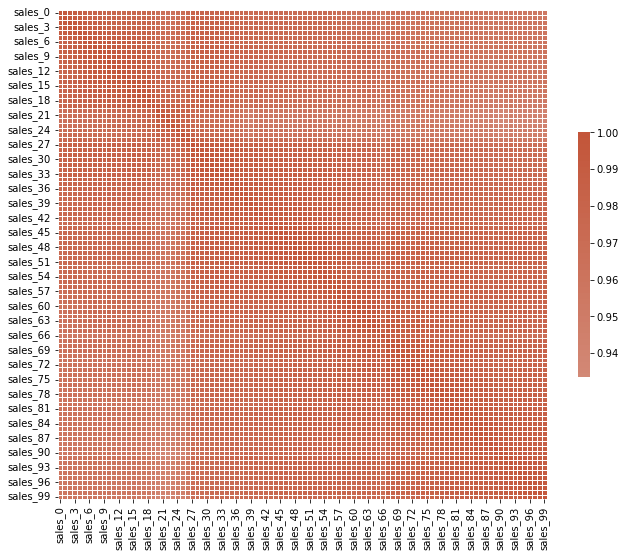

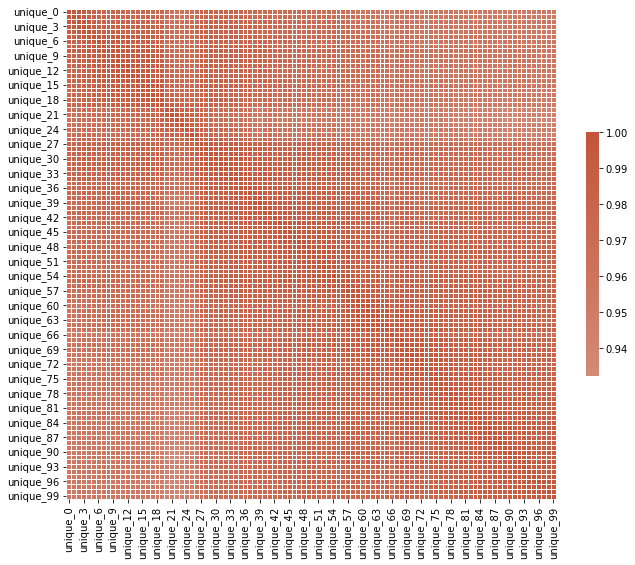

In [17]:
heatmap(customer_sales_board)
heatmap(customer_unique_board)

#### Recherche d'outliers

In [4]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,average_cart_articles,average_cart_price,total_carts,total_articles,...,repurchases,repurchases_interval,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,postal_code_group,group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,NONE,49,1.900000,0.054393,10,21,...,0,0.000000,0.0,0.0,0.0,0.6,0.4,0.0,4,7
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,NONE,25,3.250000,0.100510,24,86,...,14,5.285714,0.0,1.0,0.0,0.0,0.0,0.0,4,1
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,NONE,24,2.142857,0.086646,7,18,...,1,0.000000,0.1,0.9,0.0,0.0,0.0,0.0,4,1
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,NONE,54,2.000000,0.060983,1,2,...,0,0.000000,0.0,0.0,0.0,0.1,0.9,0.0,1,4
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,Regularly,52,2.166667,0.078282,6,13,...,1,2.000000,0.0,0.0,0.0,0.3,0.7,0.0,1,3


In [23]:
pd.options.display.float_format = '{:,.2f}'.format
customers[['average_cart_interval', 'total_articles', 'total_carts','repurchases']].describe(
    percentiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999, 0.99999]
)

,average_cart_interval,total_articles,total_carts,repurchases
count,"914,308.00","1,371,980.00","1,371,980.00","1,371,980.00"
mean,12.91,23.17,6.69,1.10
std,13.46,39.15,9.87,3.56
min,0.14,0.00,0.00,0.00
10%,2.58,1.00,1.00,0.00
20%,4.18,3.00,1.00,0.00
30%,5.57,4.00,1.00,0.00
40%,7.00,6.00,2.00,0.00
50%,8.67,9.00,3.00,0.00
60%,10.77,14.00,4.00,0.00


**Nous avons donc effectivement des outliers**<br/>
-> On choisit de les tagger afin de ne pas les inclure dans le jeu d'entraînement.